In [2]:
import numpy as np
import pandas as pd

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [4]:
import yfinance as yf

In [5]:
def max_drawdown(cum_returns: pd.Series) -> float:
    peak = cum_returns.cummax()
    dd = (cum_returns / peak) - 1.0
    return dd.min()

In [ ]:
def make_features(prices: pd.DataFrame, mkt_col: str = None) -> pd.DataFrame:
    # prices: Adj Close (date x ticker)
    rets = np.log(prices).diff().dropna()

    feats = []
    for t in rets.columns:
        r = rets[t].dropna()
        ann_ret = r.mean() * 252
        ann_vol = r.std() * np.sqrt(252)
        skew = r.skew()
        kurt = r.kurt()

        cr = (1 + r).cumprod()
        mdd = max_drawdown(cr)

        row = {
            "ann_return": ann_ret,
            "ann_vol": ann_vol,
            "skew": skew,
            "kurt": kurt,
            "mdd": mdd,
        }

        if mkt_col is not None and mkt_col in rets.columns:
            m = rets[mkt_col].dropna()
            aligned = pd.concat([r, m], axis=1).dropna()
            if len(aligned) > 50:
                beta = np.cov(aligned.iloc[:,0], aligned.iloc[:,1])[0,1] / np.var(aligned.iloc[:,1])
                corr = aligned.iloc[:,0].corr(aligned.iloc[:,1])
                row["beta_mkt"] = beta
                row["corr_mkt"] = corr
            else:
                row["beta_mkt"] = np.nan
                row["corr_mkt"] = np.nan

        feats.append(pd.Series(row, name=t))

    feat_df = pd.DataFrame(feats)
    feat_df = feat_df.dropna()
    return feat_df

In [15]:
tickers = ["005930.KS", "000660.KS", "035420.KS", "051910.KS", "068270.KS"]
data = yf.download(tickers, start="2022-01-01", auto_adjust=True)["Close"].dropna(how="all")

[*********************100%***********************]  5 of 5 completed


In [7]:
data

Ticker,000660.KS,005930.KS,035420.KS,051910.KS,068270.KS
Date,,,,,
2022-01-04,123580.265625,72439.671875,359920.53125,626883.9375,169058.265625
2022-01-05,120695.132812,71243.085938,349580.81250,646352.4375,162973.921875
2022-01-06,120214.257812,70782.859375,333332.68750,671661.3750,157324.140625
2022-01-07,122137.703125,72071.500000,332840.34375,699890.6875,158627.921875
2022-01-10,119733.414062,71795.351562,329886.15625,691129.8125,162539.312500
...,...,...,...,...,...
2025-12-29,640000.000000,119500.000000,242000.00000,338500.0000,181300.000000
2025-12-30,651000.000000,119900.000000,242500.00000,333000.0000,181000.000000
2026-01-02,677000.000000,128500.000000,247000.00000,322500.0000,202500.000000


In [8]:
feat = make_features(data)
X = StandardScaler().fit_transform(feat.values)
Z = PCA(n_components=5, random_state=0).fit_transform(X)

In [10]:
# K-means
k = 3
labels_km = KMeans(n_clusters=k, random_state=0, n_init="auto").fit_predict(Z)

In [11]:
# GMM
labels_gmm = GaussianMixture(n_components=k, random_state=0).fit_predict(Z)

In [13]:
out = feat.copy()
out["cluster_kmeans"] = labels_km
out["cluster_gmm"] = labels_gmm
out.sort_values("cluster_kmeans")

,ann_return,ann_vol,skew,kurt,mdd,cluster_kmeans,cluster_gmm
035420.KS,-0.086963,0.367259,0.563542,4.429114,-0.624517,0,0
000660.KS,0.453236,0.442793,0.017697,1.566659,-0.455473,1,1
005930.KS,0.165470,0.286567,0.206780,2.431895,-0.442294,1,1
068270.KS,0.058441,0.354782,0.243712,4.759196,-0.388010,1,1
051910.KS,-0.167246,0.441534,0.183231,2.255741,-0.821821,2,2


In [14]:
def log_returns(prices: pd.DataFrame | pd.Series) -> pd.DataFrame | pd.Series:
    return np.log(prices).diff()

In [17]:
data = log_returns(data)

In [19]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
000660.KS,976.0,0.001804,0.027898,-0.109796,-0.013548,0.000000,0.017769,0.104633
005930.KS,976.0,0.000661,0.018051,-0.108716,-0.010130,0.000000,0.009472,0.072049
035420.KS,976.0,-0.000337,0.023147,-0.093503,-0.013396,0.000000,0.010071,0.164817
051910.KS,976.0,-0.000672,0.027817,-0.136033,-0.016471,-0.001821,0.013065,0.122269
068270.KS,976.0,0.000232,0.022349,-0.131336,-0.011323,0.000000,0.010465,0.138791


# 0단계) 데이터 준비 (Close → log return)

In [20]:
import numpy as np
import pandas as pd
import yfinance as yf

tickers = ["005930.KS", "000660.KS", "035420.KS", "051910.KS", "068270.KS"]
prices = yf.download(tickers, start="2022-01-01", auto_adjust=True, progress=False)["Close"]
prices = prices.dropna(how="all")

log_ret = np.log(prices).diff()  # 날짜 x 종목


# 1단계) “피쳐별 시계열 벡터” 만들기 (10일 rolling + log return 포함)

핵심: 각 날짜마다 종목별로 다음 피쳐들을 만들고, 그 피쳐들이 시간축으로 쌓이면 “피쳐별 시계열 벡터”가 됩니다.
- log_ret (로그수익률 자체)
- roll_mean (10일 평균)
- roll_vol (10일 표준편차)
- roll_mdd (10일 구간 MDD)

In [22]:
def rolling_mdd_from_logrets(arr: np.ndarray) -> float:
    arr = arr[~np.isnan(arr)]
    if arr.size < 2:
        return np.nan
    cum = np.exp(arr).cumprod()
    peak = np.maximum.accumulate(cum)
    dd = cum / peak - 1.0
    return float(dd.min())

def make_feature_panel(prices: pd.DataFrame, window: int = 10, min_periods: int | None = None) -> pd.DataFrame:
    if min_periods is None:
        min_periods = window

    lr = np.log(prices).diff()

    feats = pd.concat(
        {
            "log_ret": lr,
            "roll_mean": lr.rolling(window, min_periods=min_periods).mean(),
            "roll_vol": lr.rolling(window, min_periods=min_periods).std(),
            "roll_mdd": lr.rolling(window, min_periods=min_periods).apply(rolling_mdd_from_logrets, raw=True),
        },
        axis=1,
    )  # columns: (feature, ticker)

    feats = feats.stack(level=1)  # index: (date, ticker), columns: feature
    feats.index.names = ["date", "ticker"]
    return feats.dropna()

feat_panel = make_feature_panel(prices, window=10)
feat_panel.head()


/tmp/ipykernel_10485/3810722768.py:26: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  feats = feats.stack(level=1)  # index: (date, ticker), columns: feature


log_ret  roll_mean  roll_vol  roll_mdd
date       ticker                                            
2022-01-18 000660.KS -0.003945  -0.001569  0.015826 -0.023166
           005930.KS -0.006473  -0.002184  0.010618 -0.024081
           035420.KS -0.016141  -0.007822  0.021528 -0.056338
           051910.KS -0.018559   0.007477  0.035532 -0.102199
           068270.KS -0.003130  -0.019839  0.051164 -0.190355

# 2단계) 클러스터링용 “종목별 시계열 벡터”로 변환 (N×T×F 텐서)

In [23]:
def build_tensor(feat_panel: pd.DataFrame, tickers: list[str]) -> tuple[np.ndarray, pd.DatetimeIndex]:
    # 공통 날짜만 사용
    common_dates = None
    for t in tickers:
        idx = feat_panel.xs(t, level="ticker").index
        common_dates = idx if common_dates is None else common_dates.intersection(idx)
    common_dates = common_dates.sort_values()

    mats = []
    for t in tickers:
        mat = feat_panel.xs(t, level="ticker").loc[common_dates].values  # (T, F)
        mats.append(mat)

    X = np.stack(mats, axis=0)  # (N, T, F)
    return X, common_dates

X, dates = build_tensor(feat_panel, tickers)
print("X shape:", X.shape)  # (N, T, F)


X shape: (5, 967, 4)


# 3단계) (가장 쉬움) 방법 1 — “그냥 펼쳐서(Flatten) KMeans”

* 아이디어
    - 각 종목의 (T×F)를 한 줄로 펼쳐서 (T*F) 벡터로 만든 후, KMeans/GMM 등 일반 클러스터링 적용.
* 꼭 할 것: 스케일링
    - 피쳐마다 단위가 달라서 표준화는 필수입니다.
    - 여기서는 (N*T, F)로 펴서 “피쳐별” 표준화 후 다시 reshape 합니다.

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

N, T, F = X.shape

# (N*T, F)에서 피쳐별 표준화
X2 = X.reshape(N*T, F)
X2 = StandardScaler().fit_transform(X2)
Xz = X2.reshape(N, T, F)

# 종목별 벡터화(Flatten)
X_flat = Xz.reshape(N, T*F)

# (선택) PCA로 차원 축소: 종목 수가 적으면 n_components는 N 이하로
p = min(5, N, X_flat.shape[1])
Z = PCA(n_components=p, random_state=0).fit_transform(X_flat)

labels = KMeans(n_clusters=3, random_state=0, n_init="auto").fit_predict(Z)

result = pd.DataFrame({"ticker": tickers, "cluster": labels}).set_index("ticker")
print(result.sort_values("cluster"))


           cluster
ticker            
035420.KS        0
068270.KS        0
051910.KS        1
000660.KS        2
005930.KS        2


# 4단계) 방법 2 — Flatten + “거리행렬” + 계층적 클러스터링 (쉬운 편, 해석 좋음)

* 아이디어
    - Flatten한 벡터로 종목 간 거리를 만든 뒤(예: 유클리드), Hierarchical(병합)으로 군집화.

In [25]:
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

D = pairwise_distances(X_flat, metric="euclidean")  # (N,N)

# scikit-learn 버전 호환(affinity vs metric)
try:
    model = AgglomerativeClustering(n_clusters=3, metric="precomputed", linkage="average")
except TypeError:
    model = AgglomerativeClustering(n_clusters=3, affinity="precomputed", linkage="average")

labels_h = model.fit_predict(D)

result_h = pd.DataFrame({"ticker": tickers, "cluster": labels_h}).set_index("ticker")
print(result_h.sort_values("cluster"))


           cluster
ticker            
035420.KS        0
068270.KS        0
051910.KS        1
000660.KS        2
005930.KS        2


# 5단계) 방법 3 — (시계열 클러스터링 정석) DTW 기반 KMeans (중간 난이도)

- 아이디어
    - 유클리드 대신 DTW 거리를 써서 “시간축이 조금 밀려도 비슷하면 가깝게” 보게 함.
    - 이게 “시계열 벡터” 클러스터링에서 가장 많이 쓰는 정석 중 하나입니다.

In [28]:
# pip install tslearn

In [29]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

# X: (N,T,F)
X_scaled = TimeSeriesScalerMeanVariance().fit_transform(X)  # 각 시계열을 평균0/분산1로 정규화

km_dtw = TimeSeriesKMeans(n_clusters=3, metric="dtw", random_state=0)
labels_dtw = km_dtw.fit_predict(X_scaled)

result_dtw = pd.DataFrame({"ticker": tickers, "cluster": labels_dtw}).set_index("ticker")
print(result_dtw.sort_values("cluster"))


/opt/conda/lib/python3.11/site-packages/tslearn/bases/bases.py:16: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


           cluster
ticker            
068270.KS        0
051910.KS        1
035420.KS        1
000660.KS        2
005930.KS        2


# 6단계) 방법 4 — “피쳐별 시계열 거리”를 따로 만들고 가중합해서 클러스터링 (실무형, 유연함)

- 아이디어
    - 피쳐마다 성격이 다르니, 피쳐별로 거리(유사도)를 계산하고 가중합해서 최종 거리행렬로 클러스터링.
    - 가장 쉬운 형태로는 피쳐별 상관거리(1-corr) 를 합치는 방식이 있습니다.

In [30]:
D = np.zeros((N, N), dtype=float)

# Xz: (N,T,F) (이미 표준화된 텐서)
for f in range(F):
    A = Xz[:, :, f]               # (N,T)
    C = np.corrcoef(A)            # (N,N)
    D += (1.0 - C)                # 상관거리 누적

D /= F

try:
    model = AgglomerativeClustering(n_clusters=3, metric="precomputed", linkage="average")
except TypeError:
    model = AgglomerativeClustering(n_clusters=3, affinity="precomputed", linkage="average")

labels_mix = model.fit_predict(D)

result_mix = pd.DataFrame({"ticker": tickers, "cluster": labels_mix}).set_index("ticker")
print(result_mix.sort_values("cluster"))


           cluster
ticker            
005930.KS        0
000660.KS        0
051910.KS        0
068270.KS        1
035420.KS        2


# 7단계) k(클러스터 개수) 선택하기 — 가장 쉬운 것부터

- 중요: 지금 예시처럼 종목이 5개면(k 후보가 2~4 정도) 지표가 매우 불안정합니다.
- 가능하면 20개 이상으로 늘려서 보시는 걸 추천합니다.

## 7-1) Elbow (관성, inertia) + Silhouette (실루엣) : Flatten + KMeans용

   k      inertia  silhouette
0  2  7991.473050    0.083734
1  3  4609.930736    0.066949
2  4  2070.490806    0.045384


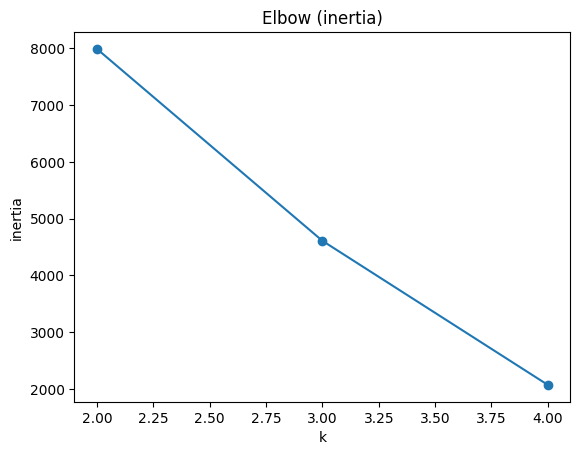

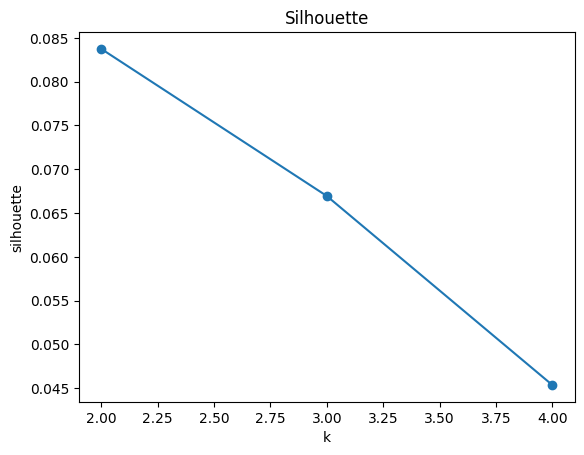

In [31]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def choose_k_kmeans(X_flat, k_min=2, k_max=10, random_state=0):
    n = X_flat.shape[0]
    k_max = min(k_max, n-1)  # silhouette는 k < n 필요
    ks, inertias, sils = [], [], []

    for k in range(k_min, k_max+1):
        km = KMeans(n_clusters=k, random_state=random_state, n_init="auto").fit(X_flat)
        ks.append(k)
        inertias.append(km.inertia_)
        sils.append(silhouette_score(X_flat, km.labels_))

    return pd.DataFrame({"k": ks, "inertia": inertias, "silhouette": sils})

scores = choose_k_kmeans(X_flat, k_min=2, k_max=10)
print(scores)

plt.figure()
plt.plot(scores["k"], scores["inertia"], marker="o")
plt.title("Elbow (inertia)")
plt.xlabel("k"); plt.ylabel("inertia")
plt.show()

plt.figure()
plt.plot(scores["k"], scores["silhouette"], marker="o")
plt.title("Silhouette")
plt.xlabel("k"); plt.ylabel("silhouette")
plt.show()


# 8단계) “클러스터가 무엇을 의미하는지” 해석하기 (가장 유용)

- 여기서는 KMeans를 X_flat에 직접 fit했다고 가정하고(가장 해석 쉬움),
- 각 클러스터의 “대표 시계열(centroid)”을 다시 (T×F) 로 되돌려 봅니다.

## 8-1) KMeans 학습 + 결과 테이블

In [32]:
from sklearn.cluster import KMeans

k = 3
km = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(X_flat)
labels = km.labels_

res = pd.DataFrame({"ticker": tickers, "cluster": labels}).set_index("ticker")
print(res.sort_values("cluster"))


           cluster
ticker            
035420.KS        0
068270.KS        0
051910.KS        1
000660.KS        2
005930.KS        2


## 8-2) 클러스터별 “대표 궤적(centroid)”을 피쳐별로 그리기

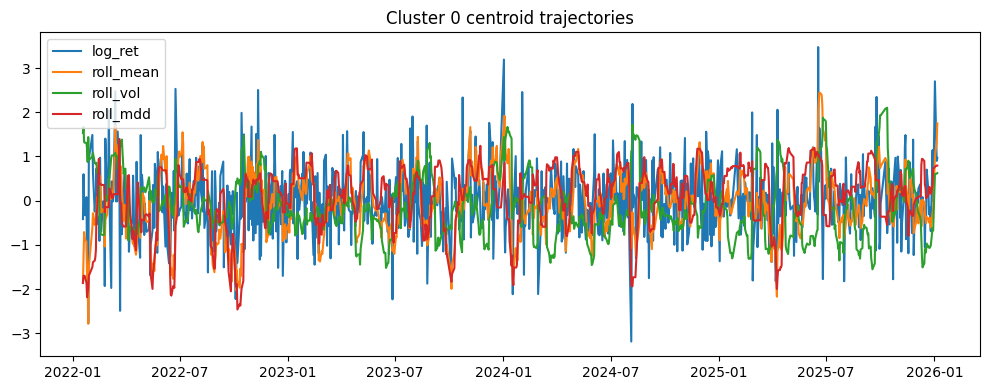

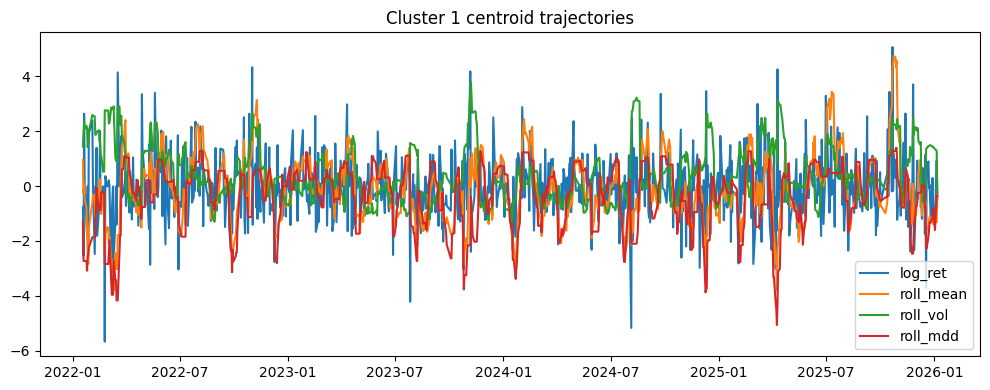

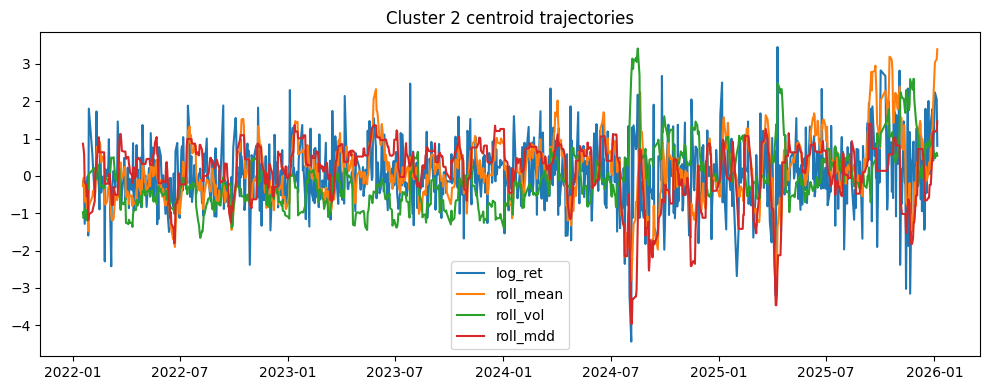

In [33]:
import matplotlib.pyplot as plt

feature_names = list(feat_panel.columns)  # ["log_ret","roll_mean","roll_vol","roll_mdd"] 등
N, T, F = Xz.shape

centroids = km.cluster_centers_           # (k, T*F)
centroids_tf = centroids.reshape(k, T, F) # (k, T, F)

for c in range(k):
    plt.figure(figsize=(10, 4))
    for f in range(F):
        plt.plot(dates, centroids_tf[c, :, f], label=feature_names[f])
    plt.title(f"Cluster {c} centroid trajectories")
    plt.legend()
    plt.tight_layout()
    plt.show()


- 이 그림이 바로 “이 클러스터는 어떤 상태/패턴이냐?”를 보여줍니다.
- 예를 들어:
    - roll_vol이 꾸준히 높은 클러스터
    - roll_mean이 양(+)으로 유지되는 클러스터
    - roll_mdd가 크게 내려가는 구간이 잦은 클러스터

같은 해석이 가능합니다.

## 8-3) 클러스터별 피쳐 평균(요약 프로파일)

In [34]:
# 종목별 (T,F) -> 시간평균해서 (N,F)
ticker_summary = pd.DataFrame(
    Xz.mean(axis=1),  # (N,F)
    index=tickers,
    columns=feature_names
).join(res)

print(ticker_summary.groupby("cluster")[feature_names].mean())


          log_ret  roll_mean  roll_vol  roll_mdd
cluster                                         
0       -0.012603  -0.045875 -0.130843  0.084115
1       -0.047945  -0.132103  0.427340 -0.405893
2        0.036576   0.111927 -0.082827  0.118831


# 9단계) 클러스터 “안정성/품질” 체크 (쉬운 진단)

각 종목이 자기 클러스터 중심에서 얼마나 먼지 (이상치 확인)

In [35]:
import numpy as np

cent = km.cluster_centers_
dists = np.linalg.norm(X_flat - cent[labels], axis=1)  # 각 샘플이 자기 중심까지 거리

diag = res.copy()
diag["dist_to_centroid"] = dists
print(diag.sort_values(["cluster", "dist_to_centroid"], ascending=[True, False]))


           cluster  dist_to_centroid
ticker                              
035420.KS        0      3.563313e+01
068270.KS        0      3.563313e+01
051910.KS        1      2.620059e-15
005930.KS        2      3.217523e+01
000660.KS        2      3.217523e+01


# 10단계) DTW(시계열 거리)로 했을 때도 똑같이 “해석”하기 (선택)

DTW는 “시간축이 살짝 밀린 패턴”에도 강합니다. 다만 centroid 해석은 KMeans(flatten)보다 직관이 덜할 수 있어요. 그래도 클러스터별 평균 궤적은 동일하게 볼 수 있습니다.

           cluster
ticker            
068270.KS        0
051910.KS        1
035420.KS        1
000660.KS        2
005930.KS        2


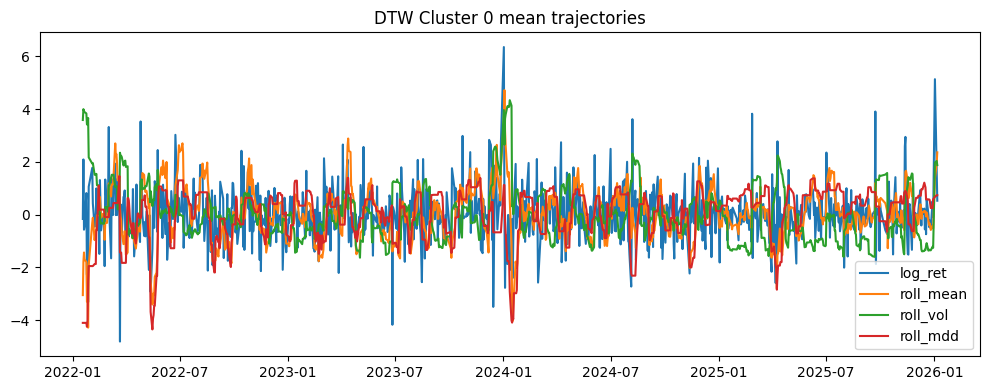

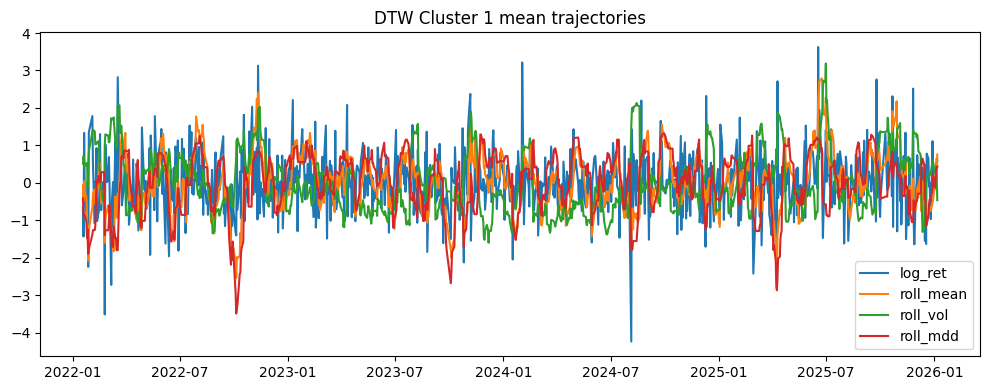

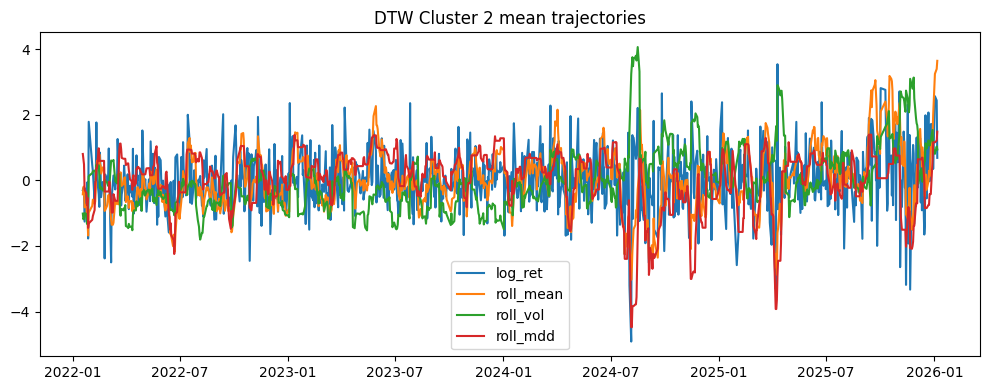

In [36]:
# pip install tslearn
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans

X_scaled = TimeSeriesScalerMeanVariance().fit_transform(X)  # (N,T,F)

k = 3
km_dtw = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=0)
labels_dtw = km_dtw.fit_predict(X_scaled)

res_dtw = pd.DataFrame({"ticker": tickers, "cluster": labels_dtw}).set_index("ticker")
print(res_dtw.sort_values("cluster"))

# 클러스터별 평균 궤적(centroid 대신 mean trajectory)
for c in range(k):
    members = np.where(labels_dtw == c)[0]
    if len(members) == 0:
        continue
    mean_traj = X_scaled[members].mean(axis=0)  # (T,F)

    plt.figure(figsize=(10,4))
    for f in range(F):
        plt.plot(dates, mean_traj[:, f], label=feature_names[f])
    plt.title(f"DTW Cluster {c} mean trajectories")
    plt.legend()
    plt.tight_layout()
    plt.show()


# 11단계) (추천) 피쳐를 조금 더 “실무형”으로 늘리는 방법

- 요청하신 로그수익률(log_ret) 은 이미 포함했고, 실무에서는 보통 아래를 추가하면 군집이 더 잘 나뉩니다.
    - roll_mean 대신/추가로 누적수익률(cumret_10d)
    - 모멘텀(추세): 10일 선형회귀 기울기(slope)
    - 점프/변동성 급등: vol z-score 같은 것

예: 10일 누적(logret 합) 추가

In [38]:
def add_more_features(feat_panel: pd.DataFrame, prices: pd.DataFrame, window=10):
    lr = np.log(prices).diff()
    cum_logret = lr.rolling(window, min_periods=window).sum()  # 10일 log수익률 합

    extra = pd.concat({"cum_logret": cum_logret}, axis=1).stack(level=1)
    extra.index.names = ["date", "ticker"]

    return feat_panel.join(extra, how="inner")

feat_panel2 = add_more_features(feat_panel, prices, window=10)
print(feat_panel2.head())


                       log_ret  roll_mean  roll_vol  roll_mdd  cum_logret
date       ticker                                                        
2022-01-18 000660.KS -0.003945  -0.001569  0.015826 -0.023166   -0.015687
           005930.KS -0.006473  -0.002184  0.010618 -0.024081   -0.021838
           035420.KS -0.016141  -0.007822  0.021528 -0.056338   -0.078220
           051910.KS -0.018559   0.007477  0.035532 -0.102199    0.074773
           068270.KS -0.003130  -0.019839  0.051164 -0.190355   -0.198388


/tmp/ipykernel_10485/3044875272.py:5: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  extra = pd.concat({"cum_logret": cum_logret}, axis=1).stack(level=1)


좋아요. 그럼 “종목(객체) = 하나의 멀티피쳐 시계열(T×F)” 을 기준으로 클러스터링을 끝까지 가져가려면, 보통 다음 4가지를 더 합니다:

1. 분석 기간(최근 1년/2년/전체) 자르기
2. k 후보별 결과를 한 번에 비교
3. 클러스터 안정성(기간을 바꿔도 비슷한가) 점검
4. 리포트 형태로 정리(클러스터 프로파일/대표 종목/저장)

아래는 그대로 복붙해서 실행 가능한 “추가 단계 코드”입니다.
(전제: 앞에서 만든 prices, tickers, feat_panel, X, dates, Xz, X_flat, feature_names가 있다고 가정합니다. 없으면 0~2단계부터 먼저 실행.)

# 12단계) 기간 자르기: “최근 N영업일” 또는 “최근 1년”만으로 종목 시계열 벡터 만들기

## 12-1) 최근 N영업일(rolling feature 기준)만 쓰기

In [39]:
def slice_last_n_dates(feat_panel: pd.DataFrame, n: int) -> pd.DataFrame:
    # feat_panel: index=(date,ticker)
    all_dates = feat_panel.index.get_level_values("date").unique().sort_values()
    last_dates = all_dates[-n:]
    return feat_panel.loc[(last_dates, slice(None)), :]

# 예: 최근 252일(대략 1년)만
feat_panel_1y = slice_last_n_dates(feat_panel, 252)


## 12-2) 다시 (N,T,F) 텐서 / X_flat 만들기 (기간 바뀌었으니 재생성)

In [40]:
from sklearn.preprocessing import StandardScaler

def build_tensor_and_flat(feat_panel_sub: pd.DataFrame, tickers: list[str]):
    # 공통 날짜 맞추기
    common_dates = None
    for t in tickers:
        idx = feat_panel_sub.xs(t, level="ticker").index
        common_dates = idx if common_dates is None else common_dates.intersection(idx)
    common_dates = common_dates.sort_values()

    mats = []
    for t in tickers:
        mats.append(feat_panel_sub.xs(t, level="ticker").loc[common_dates].values)  # (T,F)

    X = np.stack(mats, axis=0)  # (N,T,F)

    # 피쳐별 표준화: (N*T, F)에서 스케일링
    N, T, F = X.shape
    X2 = X.reshape(N*T, F)
    X2 = StandardScaler().fit_transform(X2)
    Xz = X2.reshape(N, T, F)

    X_flat = Xz.reshape(N, T*F)
    return X, Xz, X_flat, common_dates

X_1y, Xz_1y, Xflat_1y, dates_1y = build_tensor_and_flat(feat_panel_1y, tickers)


# 13단계) k 후보별 결과를 한 번에 비교 (가장 실용적)

## 13-1) k별 라벨 테이블(종목 → 클러스터) 만들기

In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def compare_k_overview(X_flat: np.ndarray, tickers: list[str], k_list=(2,3,4,5), random_state=0):
    n = X_flat.shape[0]
    rows = []
    label_cols = {}

    for k in k_list:
        if k >= n:  # k는 n_samples보다 작아야 의미가 있음
            continue
        km = KMeans(n_clusters=k, random_state=random_state, n_init="auto").fit(X_flat)
        labels = km.labels_
        sil = silhouette_score(X_flat, labels) if (1 < k < n) else np.nan

        rows.append({"k": k, "inertia": km.inertia_, "silhouette": sil})
        label_cols[f"k={k}"] = labels

    score_df = pd.DataFrame(rows).set_index("k").sort_index()
    label_df = pd.DataFrame(label_cols, index=tickers)
    return score_df, label_df

scores_all, labels_all = compare_k_overview(Xflat_1y, tickers, k_list=(2,3,4))
print(scores_all)
print(labels_all)


       inertia  silhouette
k                         
2  1829.201019    0.132133
3  1045.127472    0.108014
4   362.123626    0.089863
           k=2  k=3  k=4
005930.KS    0    0    3
000660.KS    1    2    2
035420.KS    0    0    0
051910.KS    1    1    1
068270.KS    0    0    3


- scores_all: k별 inertia/silhouette 비교
- labels_all: 각 k에서 종목 라벨이 어떻게 달라지는지 한눈에 확인

# 14단계) 클러스터 해석(프로파일): “이 클러스터는 어떤 패턴인가?”

여기서는 예시로 k=3을 선택했다고 가정하고, 클러스터별 평균 궤적과 종목별 요약을 만듭니다.

In [42]:
import matplotlib.pyplot as plt

k = 3
km = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(Xflat_1y)
labels = km.labels_

res = pd.DataFrame({"ticker": tickers, "cluster": labels}).set_index("ticker")
print(res.sort_values("cluster"))


           cluster
ticker            
005930.KS        0
035420.KS        0
068270.KS        0
051910.KS        1
000660.KS        2


## 14-1) 클러스터 대표 궤적(centroid) 보기 (피쳐별 시계열)

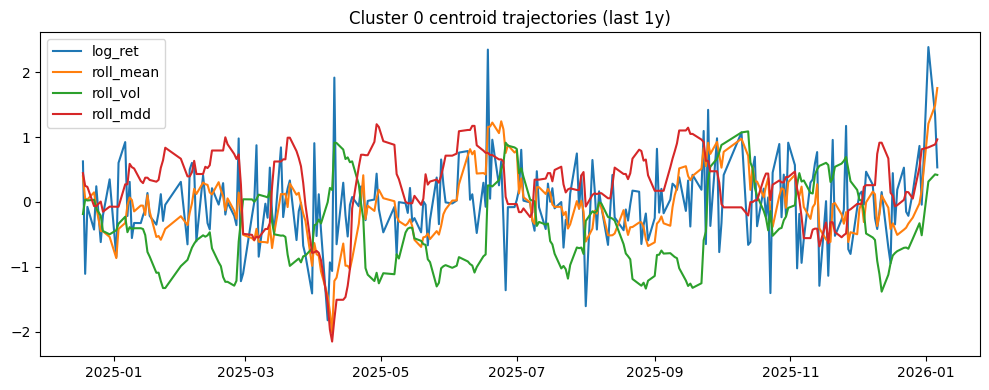

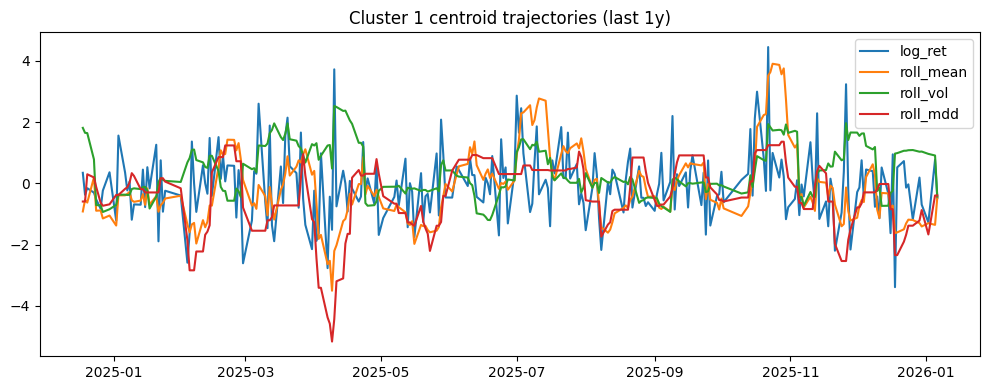

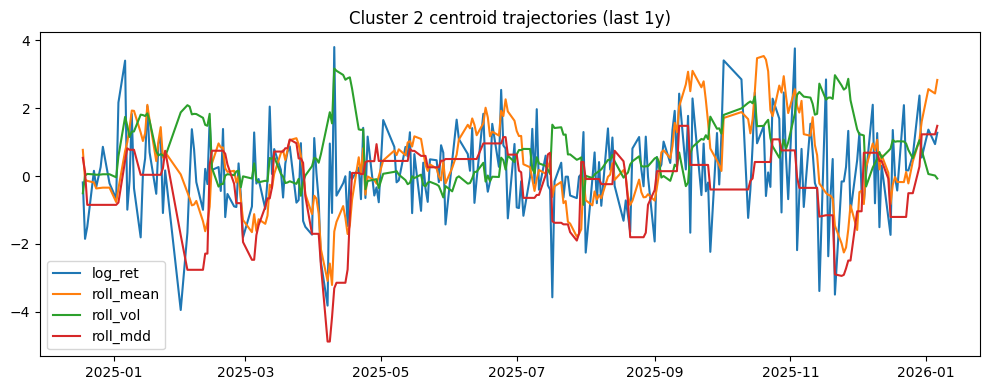

In [43]:
feature_names = list(feat_panel.columns)  # 예: ["log_ret","roll_mean","roll_vol","roll_mdd"]
N, T, F = Xz_1y.shape

centroids = km.cluster_centers_.reshape(k, T, F)  # (k,T,F)

for c in range(k):
    plt.figure(figsize=(10, 4))
    for f in range(F):
        plt.plot(dates_1y, centroids[c, :, f], label=feature_names[f])
    plt.title(f"Cluster {c} centroid trajectories (last 1y)")
    plt.legend()
    plt.tight_layout()
    plt.show()


## 14-2) 종목별 “시간평균 요약” + 클러스터별 프로파일(표)

In [44]:
ticker_summary = pd.DataFrame(
    Xz_1y.mean(axis=1),  # (N,F)
    index=tickers,
    columns=feature_names
).join(res)

print("\nCluster profile (mean over time):")
print(ticker_summary.groupby("cluster")[feature_names].mean())



Cluster profile (mean over time):
          log_ret  roll_mean  roll_vol  roll_mdd
cluster                                         
0       -0.020922  -0.073939 -0.380102  0.243842
1       -0.052160  -0.127200  0.394270 -0.404253
2        0.114925   0.349017  0.746037 -0.327274


# 15단계) 안정성 점검: “기간을 바꿔도 비슷하게 묶이나?” (쉬운 버전)

## 15-1) “최근 1년” vs “최근 2년” 라벨이 얼마나 비슷한지 (ARI)

In [45]:
from sklearn.metrics import adjusted_rand_score

# 최근 2년(대략 504일)로도 같은 절차
feat_panel_2y = slice_last_n_dates(feat_panel, 504)
X_2y, Xz_2y, Xflat_2y, dates_2y = build_tensor_and_flat(feat_panel_2y, tickers)

k = 3
lab_1y = KMeans(n_clusters=k, random_state=0, n_init="auto").fit_predict(Xflat_1y)
lab_2y = KMeans(n_clusters=k, random_state=0, n_init="auto").fit_predict(Xflat_2y)

ari = adjusted_rand_score(lab_1y, lab_2y)
print("ARI (1y vs 2y) =", ari)


ARI (1y vs 2y) = 1.0


- ARI가 1에 가까울수록 기간을 바꿔도 군집이 안정적
- 0 근처면 기간에 따라 군집이 크게 달라짐 (10일 윈도우라 노이즈가 커서 그럴 수 있음)

# 16단계) (선택) “블록 부트스트랩”으로 안정성 더 제대로 보기

시간축을 완전히 랜덤샘플하면 시계열 구조가 깨지니, 연속 블록 단위로 샘플링해서 안정성을 봅니다.

In [46]:
from sklearn.metrics import adjusted_rand_score

def block_bootstrap_indices(T: int, block: int, n_blocks: int, rng: np.random.Generator):
    starts = rng.integers(0, T - block + 1, size=n_blocks)
    idx = np.concatenate([np.arange(s, s + block) for s in starts])
    idx = idx[:T]  # 길이 맞추기
    return idx

def stability_block_bootstrap(Xz: np.ndarray, k: int, n_runs=30, block=20, random_state=0):
    rng = np.random.default_rng(random_state)
    N, T, F = Xz.shape
    n_blocks = int(np.ceil(T / block))

    labels_list = []
    for _ in range(n_runs):
        idx = block_bootstrap_indices(T, block, n_blocks, rng)
        X_boot = Xz[:, idx, :].reshape(N, -1)  # (N, T*F)
        labels = KMeans(n_clusters=min(k, N-1), random_state=0, n_init="auto").fit_predict(X_boot)
        labels_list.append(labels)

    # 모든 쌍 ARI 평균
    aris = []
    for i in range(n_runs):
        for j in range(i+1, n_runs):
            aris.append(adjusted_rand_score(labels_list[i], labels_list[j]))
    return float(np.mean(aris)), float(np.std(aris))

mean_ari, std_ari = stability_block_bootstrap(Xz_1y, k=3, n_runs=30, block=20)
print("Block-bootstrap stability ARI mean/std =", mean_ari, std_ari)


Block-bootstrap stability ARI mean/std = 0.5033452885086278 0.4634539708133959


# 17단계) 최종 리포트 저장(클러스터 결과 + 요약치)

In [47]:
final_labels = KMeans(n_clusters=3, random_state=0, n_init="auto").fit_predict(Xflat_1y)

report = pd.DataFrame({"ticker": tickers, "cluster": final_labels}).set_index("ticker")

# 종목별 요약(시간평균)도 같이 붙이기
report = report.join(pd.DataFrame(Xz_1y.mean(axis=1), index=tickers, columns=feature_names))

# CSV 저장
report.to_csv("stock_timeseries_clusters.csv", encoding="utf-8-sig")
print(report.sort_values("cluster"))
print("\nSaved: stock_timeseries_clusters.csv")


           cluster   log_ret  roll_mean  roll_vol  roll_mdd
ticker                                                     
005930.KS        0  0.053651   0.129951 -0.384731  0.296576
035420.KS        0 -0.056286  -0.167489 -0.068036 -0.044951
068270.KS        0 -0.060130  -0.184279 -0.687540  0.479902
051910.KS        1 -0.052160  -0.127200  0.394270 -0.404253
000660.KS        2  0.114925   0.349017  0.746037 -0.327274

Saved: stock_timeseries_clusters.csv


# Step 18) (설치) DTW 시계열 클러스터링 라이브러리

In [48]:
# pip install tslearn

# Step 19) 데이터 + 10일 rolling 피쳐 만들기 (log_ret 포함 + 옵션 피쳐 추가)

In [49]:
import numpy as np
import pandas as pd
import yfinance as yf

def rolling_mdd_from_logrets(arr: np.ndarray) -> float:
    arr = arr[~np.isnan(arr)]
    if arr.size < 2:
        return np.nan
    cum = np.exp(arr).cumprod()
    peak = np.maximum.accumulate(cum)
    dd = cum / peak - 1.0
    return float(dd.min())

def rolling_slope(x: pd.Series, window: int) -> pd.Series:
    # 단순 선형회귀 기울기(rolling)
    idx = np.arange(window)

    def slope_fn(v: np.ndarray) -> float:
        if np.any(np.isnan(v)):
            return np.nan
        x0 = idx - idx.mean()
        y0 = v - v.mean()
        denom = (x0**2).sum()
        return float((x0 * y0).sum() / denom) if denom != 0 else 0.0

    return x.rolling(window).apply(slope_fn, raw=True)

def make_feature_panel(prices: pd.DataFrame, window: int = 10, add_optional: bool = True) -> pd.DataFrame:
    """
    prices: date x ticker (Close)
    returns: (date, ticker) index / feature columns
    """
    lr = np.log(prices).diff()

    feats = {
        "log_ret": lr,  # 요청사항: 로그수익률 포함
        "roll_mean": lr.rolling(window, min_periods=window).mean(),
        "roll_vol": lr.rolling(window, min_periods=window).std(),
        "roll_mdd": lr.rolling(window, min_periods=window).apply(rolling_mdd_from_logrets, raw=True),
    }

    if add_optional:
        # (옵션1) 10일 누적 로그수익률(=모멘텀)
        feats["cum_logret"] = lr.rolling(window, min_periods=window).sum()

        # (옵션2) 10일 추세 기울기(로그가격의 기울기)
        logp = np.log(prices)
        feats["trend_slope"] = logp.apply(lambda s: rolling_slope(s, window))

    panel = pd.concat(feats, axis=1)            # columns: (feature, ticker)
    panel = panel.stack(level=1)                # index: (date, ticker), columns: feature
    panel.index.names = ["date", "ticker"]
    return panel.dropna()

def slice_last_n_dates(feat_panel: pd.DataFrame, n: int) -> pd.DataFrame:
    dates = feat_panel.index.get_level_values("date").unique().sort_values()
    last_dates = dates[-n:]
    return feat_panel.loc[(last_dates, slice(None)), :]

def build_tensor(feat_panel: pd.DataFrame, tickers: list[str]) -> tuple[np.ndarray, pd.DatetimeIndex, list[str]]:
    # 모든 종목이 공통으로 갖는 날짜만 사용 (T 맞추기)
    common_dates = None
    for t in tickers:
        idx = feat_panel.xs(t, level="ticker").index
        common_dates = idx if common_dates is None else common_dates.intersection(idx)
    common_dates = common_dates.sort_values()

    mats = []
    for t in tickers:
        mats.append(feat_panel.xs(t, level="ticker").loc[common_dates].values)  # (T,F)
    X = np.stack(mats, axis=0)  # (N,T,F)
    feature_names = list(feat_panel.columns)
    return X, common_dates, feature_names


# -----------------------
# Example data
# -----------------------
tickers = ["005930.KS", "000660.KS", "035420.KS", "051910.KS", "068270.KS"]
prices = yf.download(tickers, start="2022-01-01", auto_adjust=True, progress=False)["Close"].dropna(how="all")

feat_panel = make_feature_panel(prices, window=10, add_optional=True)

# 예: 최근 252영업일(대략 1년)만
feat_1y = slice_last_n_dates(feat_panel, 252)

X, dates, feature_names = build_tensor(feat_1y, tickers)
print("X shape (N,T,F) =", X.shape)
print("features =", feature_names)


X shape (N,T,F) = (5, 252, 6)
features = ['log_ret', 'roll_mean', 'roll_vol', 'roll_mdd', 'cum_logret', 'trend_slope']


/tmp/ipykernel_10485/864655013.py:51: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  panel = panel.stack(level=1)                # index: (date, ticker), columns: feature


# Step 20) DTW 거리행렬 만들기 + k 후보별 Silhouette로 k 선택

DTW는 “유클리드 좌표”가 아니라 “거리”가 핵심이라, DTW 거리행렬로 silhouette를 계산하는 게 가장 직관적입니다.

In [50]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import cdist_dtw
from sklearn.metrics import silhouette_score

# (중요) DTW는 스케일 영향이 크므로 시계열 정규화 추천
X_scaled = TimeSeriesScalerMeanVariance().fit_transform(X)  # (N,T,F)

# 종목 간 DTW 거리행렬 (N x N)
D = cdist_dtw(X_scaled)  # metric="dtw" 거리
np.fill_diagonal(D, 0.0)

def choose_k_from_distance(D: np.ndarray, k_list=(2,3,4)):
    n = D.shape[0]
    rows = []
    for k in k_list:
        if k >= n:
            continue
        # silhouette는 라벨이 있어야 하니, 아래 Step 21에서 클러스터를 만든 뒤 계산하는 게 정석인데
        # 여기서는 "각 k에 대해 클러스터링 -> silhouette"를 같이 돌립니다.
    return rows

print("DTW distance matrix:\n", pd.DataFrame(D, index=tickers, columns=tickers))


DTW distance matrix:
            005930.KS  000660.KS  035420.KS  051910.KS  068270.KS
005930.KS   0.000000  28.584965  36.087810  33.473657  33.730171
000660.KS  28.584965   0.000000  34.957340  32.963492  33.976686
035420.KS  36.087810  34.957340   0.000000  34.978964  34.880928
051910.KS  33.473657  32.963492  34.978964   0.000000  33.165988
068270.KS  33.730171  33.976686  34.880928  33.165988   0.000000


# Step 21) DTW 기반 클러스터링 (2가지 중 추천: 거리행렬+계층적)

## 21-A) (추천, 가장 안정적) DTW 거리행렬 + Agglomerative(계층적) 클러스터링
(랜덤 초기값 영향이 거의 없고, 결과가 안정적입니다.)

In [51]:
from sklearn.cluster import AgglomerativeClustering

def agglom_labels_from_distance(D: np.ndarray, k: int):
    try:
        model = AgglomerativeClustering(n_clusters=k, metric="precomputed", linkage="average")
    except TypeError:
        model = AgglomerativeClustering(n_clusters=k, affinity="precomputed", linkage="average")
    return model.fit_predict(D)

k_list = [2,3,4]
rows = []
labels_by_k = {}

for k in k_list:
    if k >= len(tickers):
        continue
    labels = agglom_labels_from_distance(D, k)
    sil = silhouette_score(D, labels, metric="precomputed")
    rows.append({"k": k, "silhouette(precomputed DTW)": sil})
    labels_by_k[f"k={k}"] = labels

scores_dtw = pd.DataFrame(rows).set_index("k").sort_index()
labels_dtw_table = pd.DataFrame(labels_by_k, index=tickers)

print(scores_dtw)
print("\nLabels by k:")
print(labels_dtw_table)


   silhouette(precomputed DTW)
k                             
2                     0.058241
3                     0.063430
4                     0.055775

Labels by k:
           k=2  k=3  k=4
005930.KS    0    2    0
000660.KS    0    2    0
035420.KS    1    1    3
051910.KS    0    0    1
068270.KS    0    0    2


## 21-B) (대안) TimeSeriesKMeans(metric="dtw")
(centroid가 나오지만, 초기값 영향이 있고 작은 N에선 덜 안정적일 수 있음)

In [52]:
from tslearn.clustering import TimeSeriesKMeans

k = 3
km_dtw = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=0)
labels_kmdtw = km_dtw.fit_predict(X_scaled)

print(pd.DataFrame({"cluster": labels_kmdtw}, index=tickers).sort_values("cluster"))


           cluster
068270.KS        0
035420.KS        1
000660.KS        2
005930.KS        2
051910.KS        2


# Step 22) DTW 클러스터 해석: “대표 패턴” + “대표 종목(메도이드)”

DTW에서는 “centroid”보다 클러스터 내부에서 가장 대표적인 종목(메도이드) 를 뽑는 해석이 특히 좋습니다.

## 22-1) 최종 k를 하나 고르고 라벨 만들기 (여기선 예: k=3)

In [54]:
k = 3
labels = agglom_labels_from_distance(D, k)

res = pd.DataFrame({"cluster": labels}, index=tickers).sort_values("cluster")
print(res)


           cluster
051910.KS        0
068270.KS        0
035420.KS        1
000660.KS        2
005930.KS        2


## 22-2) 클러스터별 평균 궤적(피쳐별 시계열) 그리기

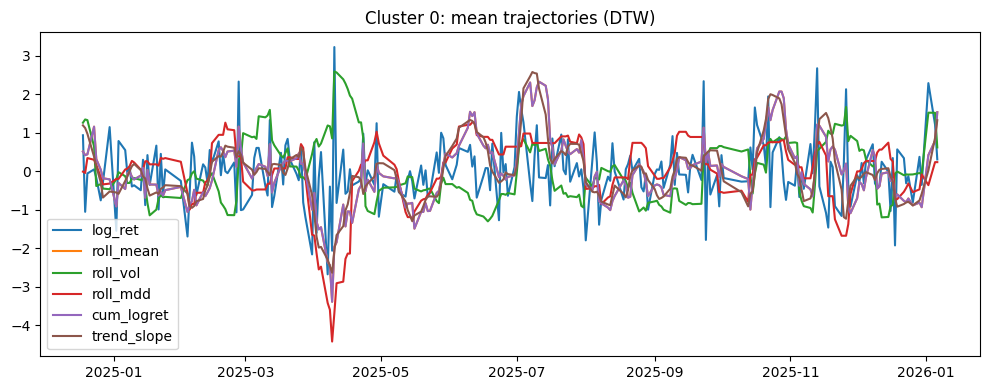

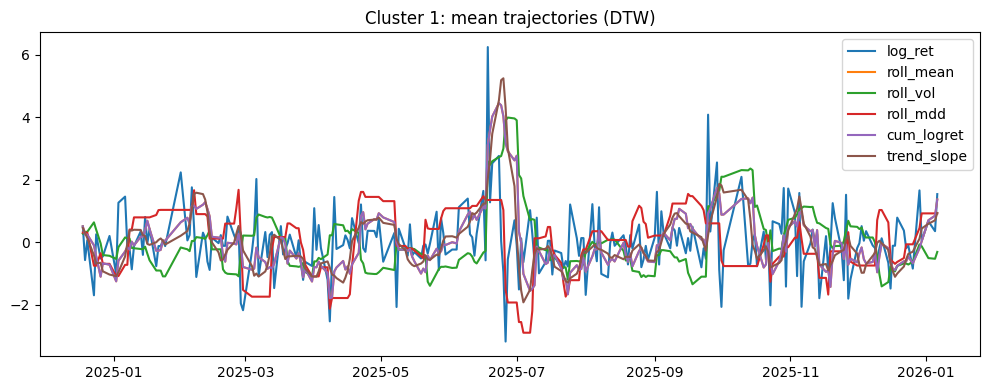

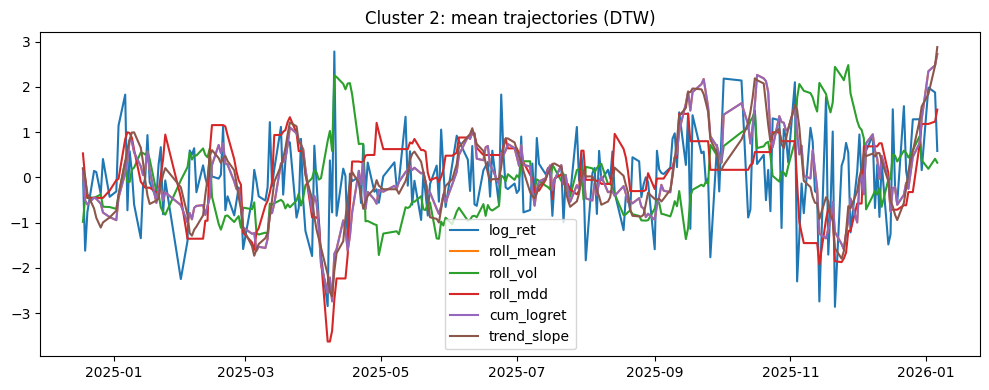

In [55]:
import matplotlib.pyplot as plt
import numpy as np

N, T, F = X_scaled.shape

for c in sorted(np.unique(labels)):
    members = np.where(labels == c)[0]
    mean_traj = X_scaled[members].mean(axis=0)  # (T,F)

    plt.figure(figsize=(10,4))
    for f in range(F):
        plt.plot(dates, mean_traj[:, f], label=feature_names[f])
    plt.title(f"Cluster {c}: mean trajectories (DTW)")
    plt.legend()
    plt.tight_layout()
    plt.show()


## 22-3) 클러스터별 “대표 종목(메도이드)” 찾기
(클러스터 내부에서 DTW 거리합이 최소인 종목)

In [56]:
def cluster_medoids(D: np.ndarray, labels: np.ndarray, tickers: list[str]):
    medoids = {}
    for c in np.unique(labels):
        idx = np.where(labels == c)[0]
        Dc = D[np.ix_(idx, idx)]
        # 각 멤버의 평균 거리(또는 합) 최소인 것이 메도이드
        avg_dist = Dc.mean(axis=1)
        m = idx[int(np.argmin(avg_dist))]
        medoids[int(c)] = tickers[m]
    return medoids

med = cluster_medoids(D, labels, tickers)
print("Medoids:", med)


Medoids: {0: '051910.KS', 1: '035420.KS', 2: '005930.KS'}


# Step 23) 안정성 체크 (DTW 버전)

## 23-A) 기간을 바꿔도 비슷한가? (최근 1년 vs 2년) ARI

In [57]:
from sklearn.metrics import adjusted_rand_score
from tslearn.metrics import cdist_dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# 최근 2년(대략 504일)
feat_2y = slice_last_n_dates(feat_panel, 504)
X2, dates2, _ = build_tensor(feat_2y, tickers)
X2s = TimeSeriesScalerMeanVariance().fit_transform(X2)
D2 = cdist_dtw(X2s)
np.fill_diagonal(D2, 0.0)

k = 3
lab_1y = agglom_labels_from_distance(D, k)
lab_2y = agglom_labels_from_distance(D2, k)

ari = adjusted_rand_score(lab_1y, lab_2y)
print("ARI (DTW, 1y vs 2y) =", ari)


ARI (DTW, 1y vs 2y) = 0.21052631578947367


- 1에 가까울수록 안정적
- 0 근처면 기간에 민감 (10일 윈도우는 민감할 수 있습니다)

# Step 24) 최종 리포트 저장 (DTW 결과)

In [58]:
# 종목별 시간평균 요약(해석용): (T,F) 평균
summary = pd.DataFrame(X_scaled.mean(axis=1), index=tickers, columns=feature_names)
report = pd.concat([res, summary], axis=1)

# 메도이드 정보도 붙이기(클러스터별)
report["cluster_medoid"] = report["cluster"].map(med)

report.to_csv("dtw_timeseries_clusters.csv", encoding="utf-8-sig")
print(report.sort_values("cluster"))
print("\nSaved: dtw_timeseries_clusters.csv")


           cluster       log_ret     roll_mean      roll_vol      roll_mdd  \
051910.KS        0  2.213838e-17  1.288652e-17 -2.308559e-16 -9.297636e-17   
068270.KS        0  4.758099e-17  2.290936e-17 -5.621605e-16 -1.130930e-15   
035420.KS        1 -2.114711e-17  1.409807e-17  2.039815e-16  2.048626e-16   
000660.KS        2 -8.811294e-18 -2.572898e-16  1.964919e-16  7.489600e-17   
005930.KS        2 -6.608470e-19  1.762259e-17 -1.691768e-16 -5.603983e-16   

             cum_logret   trend_slope cluster_medoid  
051910.KS  2.973812e-17  3.480461e-17      051910.KS  
068270.KS  3.524518e-18 -2.114711e-17      051910.KS  
035420.KS  7.049035e-17  4.625929e-17      035420.KS  
000660.KS -7.049035e-18  3.524518e-18      005930.KS  
005930.KS  6.167906e-17  1.762259e-17      005930.KS  

Saved: dtw_timeseries_clusters.csv


# Step 25) Soft-DTW로 클러스터링 (DTW보다 매끄럽고 최적화가 잘 됨)

## 25-1) 준비: 최근 1년(예: 252일)로 텐서 만들기 + 스케일링

In [59]:
import numpy as np
import pandas as pd

from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# 예: 최근 1년
feat_1y = slice_last_n_dates(feat_panel, 252)
X, dates, feature_names = build_tensor(feat_1y, tickers)  # (N,T,F)

# Soft-DTW/DTW는 스케일 영향 큼 → 정규화 강추
X_scaled = TimeSeriesScalerMeanVariance().fit_transform(X)  # (N,T,F)

print("X_scaled shape:", X_scaled.shape)
print("features:", feature_names)


X_scaled shape: (5, 252, 6)
features: ['log_ret', 'roll_mean', 'roll_vol', 'roll_mdd', 'cum_logret', 'trend_slope']


## 25-2) Soft-DTW KMeans

In [60]:
# pip install tslearn
from tslearn.clustering import TimeSeriesKMeans

k = 3
km_soft = TimeSeriesKMeans(
    n_clusters=k,
    metric="softdtw",
    metric_params={"gamma": 1.0},  # gamma가 작을수록 DTW에 가까움(보통 0.1~2 사이 탐색)
    random_state=0
)
labels_soft = km_soft.fit_predict(X_scaled)

res_soft = pd.DataFrame({"cluster_softdtw": labels_soft}, index=tickers).sort_values("cluster_softdtw")
print(res_soft)


           cluster_softdtw
068270.KS                0
035420.KS                1
000660.KS                2
005930.KS                2
051910.KS                2


## 25-3) Soft-DTW 클러스터 해석(클러스터별 평균 궤적)

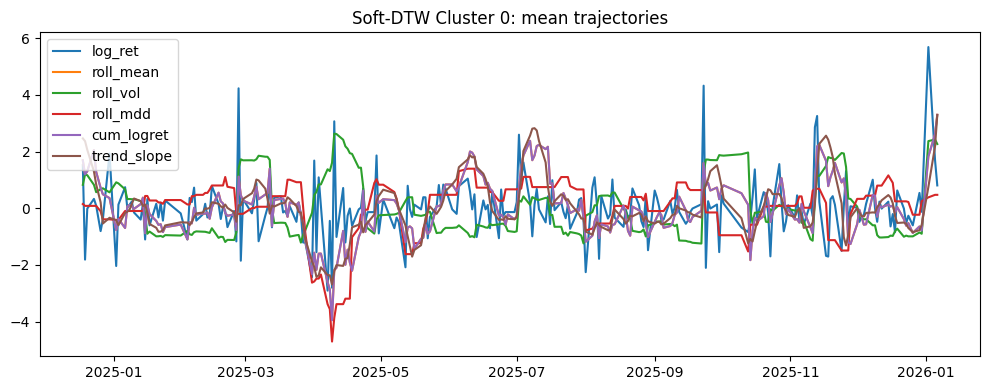

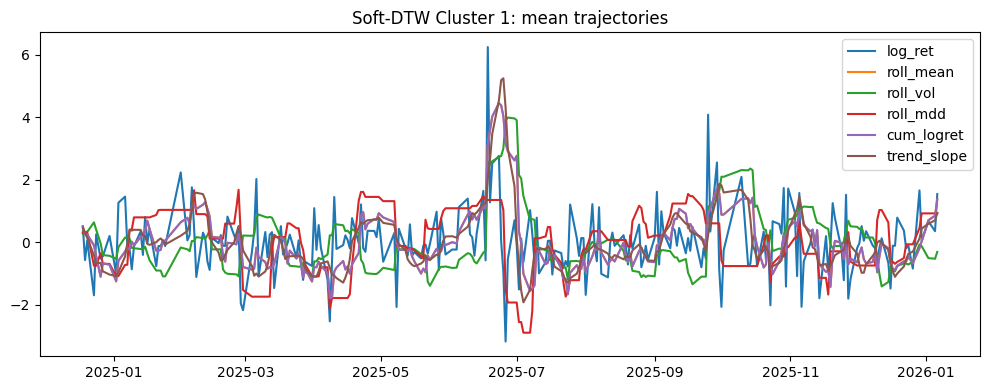

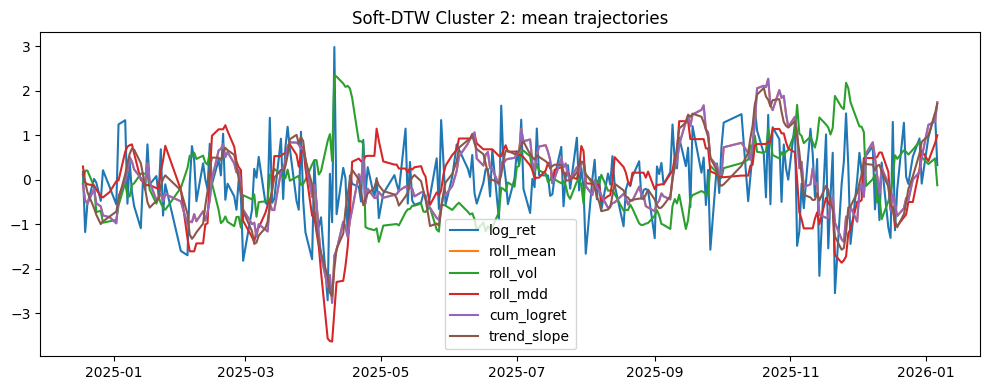

In [61]:
import matplotlib.pyplot as plt

N, T, F = X_scaled.shape

for c in sorted(np.unique(labels_soft)):
    idx = np.where(labels_soft == c)[0]
    mean_traj = X_scaled[idx].mean(axis=0)  # (T,F)

    plt.figure(figsize=(10,4))
    for f in range(F):
        plt.plot(dates, mean_traj[:, f], label=feature_names[f])
    plt.title(f"Soft-DTW Cluster {c}: mean trajectories")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Step 26) Soft-DTW “거리행렬” 기반 계층적 클러스터링 (안정적 + silhouette 가능)
KMeans(softdtw)은 초기값 영향이 있을 수 있으니, 거리행렬 + 계층적도 같이 쓰면 좋아요.

In [62]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# tslearn 버전에 따라 함수명이 다를 수 있어 try로 처리
try:
    from tslearn.metrics import cdist_soft_dtw
    D_soft = cdist_soft_dtw(X_scaled, gamma=1.0)
except Exception:
    # 대안: normalized 버전이 있으면 사용
    from tslearn.metrics import cdist_soft_dtw_normalized
    D_soft = cdist_soft_dtw_normalized(X_scaled, gamma=1.0)

np.fill_diagonal(D_soft, 0.0)

def agglom_from_precomputed(D, k):
    try:
        m = AgglomerativeClustering(n_clusters=k, metric="precomputed", linkage="average")
    except TypeError:
        m = AgglomerativeClustering(n_clusters=k, affinity="precomputed", linkage="average")
    return m.fit_predict(D)

k_list = [2,3,4]
rows = []
labels_table = {}

for k in k_list:
    if k >= len(tickers):
        continue
    lab = agglom_from_precomputed(D_soft, k)
    sil = silhouette_score(D_soft, lab, metric="precomputed")
    rows.append({"k": k, "silhouette_softdtw": sil})
    labels_table[f"k={k}"] = lab

print(pd.DataFrame(rows).set_index("k"))
print(pd.DataFrame(labels_table, index=tickers))


   silhouette_softdtw
k                    
2            0.113804
3            0.132705
4            0.115962
           k=2  k=3  k=4
005930.KS    0    2    0
000660.KS    0    2    0
035420.KS    1    1    3
051910.KS    0    0    1
068270.KS    0    0    2


# Step 27) (실무형) “피쳐별 시계열”을 따로 보고, 거리들을 섞어서 클러스터링

여기가 질문하신 “피쳐별 시계열 벡터”를 가장 정교하게 반영하는 방법입니다.

* 아이디어
    - log_ret, cum_logret, roll_mean 같은 수익/모멘텀 계열: 상관거리(1−corr)가 잘 맞는 편
    - roll_vol, roll_mdd 같은 리스크/드로다운 계열: DTW/Soft-DTW가 잘 맞는 편

그걸 가중합 거리행렬로 만들고 → Agglomerative(거리기반) 로 군집화합니다.

## 27-1) (N,T,F)에서 “특정 피쳐만” 골라 거리 계산하는 유틸

In [64]:
from sklearn.metrics import pairwise_distances
from tslearn.metrics import cdist_dtw

def feature_index_map(feature_names):
    return {name: i for i, name in enumerate(feature_names)}

def corr_distance_matrix(X_scaled, f_idx):
    """
    X_scaled: (N,T,F)
    f_idx: feature index (int)
    returns: (N,N) correlation distance (1-corr) using the time series of that feature
    """
    A = X_scaled[:, :, f_idx]  # (N,T)
    C = np.corrcoef(A)         # (N,N)
    D = 1.0 - C
    np.fill_diagonal(D, 0.0)
    return D

def dtw_distance_matrix_on_features(X_scaled, f_indices):
    """
    f_indices: list[int] (선택한 피쳐들로 구성된 멀티변수 DTW)
    """
    X_sub = X_scaled[:, :, f_indices]  # (N,T,len(f_indices))
    D = cdist_dtw(X_sub)
    np.fill_diagonal(D, 0.0)
    return D


## 27-2) 어떤 피쳐를 어떤 거리로 볼지 “정책”을 정하고 혼합 거리 만들기

In [65]:
fmap = feature_index_map(feature_names)

# 아래는 예시 정책입니다 (feat_panel에서 add_optional=True라면 cum_logret, trend_slope가 있을 수 있음)
# 실제로 feature_names에 없는 건 자동으로 제외하도록 처리
ret_like = [x for x in ["log_ret", "roll_mean", "cum_logret"] if x in fmap]
risk_like = [x for x in ["roll_vol", "roll_mdd"] if x in fmap]
trend_like = [x for x in ["trend_slope"] if x in fmap]

# 거리행렬 구성
D_mix = np.zeros((len(tickers), len(tickers)), dtype=float)

# (A) 수익/모멘텀 계열은 상관거리로 평균
if ret_like:
    Ds = []
    for name in ret_like:
        Ds.append(corr_distance_matrix(X_scaled, fmap[name]))
    D_ret = np.mean(Ds, axis=0)
else:
    D_ret = 0.0

# (B) 리스크 계열은 (멀티변수) DTW로
if risk_like:
    D_risk = dtw_distance_matrix_on_features(X_scaled, [fmap[x] for x in risk_like])
else:
    D_risk = 0.0

# (C) 추세는 상관거리 or DTW 중 택1 (예: 상관거리)
if trend_like:
    D_trend = corr_distance_matrix(X_scaled, fmap[trend_like[0]])
else:
    D_trend = 0.0

# 가중치(원하면 조정)
w_ret, w_risk, w_trend = 0.5, 0.4, 0.1

D_mix = w_ret * D_ret + w_risk * D_risk + w_trend * D_trend
np.fill_diagonal(D_mix, 0.0)

# 혼합 거리로 계층적 클러스터링
k = 3
labels_mix = agglom_from_precomputed(D_mix, k)

res_mix = pd.DataFrame({"cluster_hybrid": labels_mix}, index=tickers).sort_values("cluster_hybrid")
print(res_mix)

# 혼합 거리 기준 silhouette (precomputed)
from sklearn.metrics import silhouette_score
sil_mix = silhouette_score(D_mix, labels_mix, metric="precomputed")
print("Hybrid silhouette:", sil_mix)


           cluster_hybrid
005930.KS               0
000660.KS               0
068270.KS               0
035420.KS               1
051910.KS               2
Hybrid silhouette: 0.033243393544431274


- 이 방법이 “피쳐별 시계열 벡터”를 가장 명시적으로 반영합니다.
- 가중치(w_ret, w_risk, w_trend)를 바꾸면 “무엇을 더 중요하게 묶을지”를 컨트롤할 수 있어요.

# Step 28) 덴드로그램(계층적)으로 결과를 시각적으로 확인 (선택)

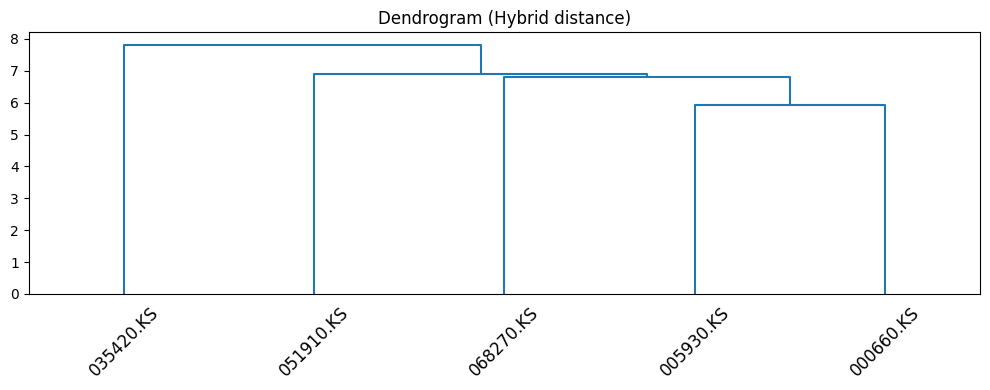

In [67]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# D_mix 같은 precomputed 거리행렬로 덴드로그램
condensed = squareform(D_mix, checks=False)
Z = linkage(condensed, method="average")

plt.figure(figsize=(10, 4))
dendrogram(Z, labels=tickers, leaf_rotation=45)
plt.title("Dendrogram (Hybrid distance)")
plt.tight_layout()
plt.show()


# Step 29) 방법별 결과를 한 표로 비교 + “합의(consensus)” 보기

종목 수가 적을수록 라벨이 흔들릴 수 있으니, 방법별 라벨을 나란히 비교하면 좋습니다.

In [68]:
compare = pd.DataFrame(index=tickers)
compare["softdtw_kmeans"] = labels_soft
compare["softdtw_agglom"] = agglom_from_precomputed(D_soft, 3)
compare["hybrid_agglom"] = labels_mix
print(compare)


           softdtw_kmeans  softdtw_agglom  hybrid_agglom
005930.KS               2               2              0
000660.KS               2               2              0
035420.KS               1               1              1
051910.KS               2               0              2
068270.KS               0               0              0


(선택) 단순 합의: 3개 중 2개 이상 같은 라벨끼리 묶고 싶다면?

라벨 번호는 방법마다 의미가 다를 수 있어 “완전한 합의 클러스터”는 조금 더 공정한 절차(공동배치)가 필요하지만, 작은 N에서는 우선 위 표 비교만으로도 충분히 인사이트가 나옵니다.

# Step 30) 최종 리포트 저장 (방법별 결과 + 요약 통계 포함)

In [69]:
# 종목별 평균 요약(해석용): (T,F) 평균
summary = pd.DataFrame(X_scaled.mean(axis=1), index=tickers, columns=feature_names)

report = summary.copy()
report = report.join(compare)

report.to_csv("timeseries_cluster_report.csv", encoding="utf-8-sig")
print(report.head())
print("\nSaved: timeseries_cluster_report.csv")


                log_ret     roll_mean      roll_vol      roll_mdd  \
005930.KS -6.608470e-19  1.762259e-17 -1.691768e-16 -5.603983e-16   
000660.KS -8.811294e-18 -2.572898e-16  1.964919e-16  7.489600e-17   
035420.KS -2.114711e-17  1.409807e-17  2.039815e-16  2.048626e-16   
051910.KS  2.213838e-17  1.288652e-17 -2.308559e-16 -9.297636e-17   
068270.KS  4.758099e-17  2.290936e-17 -5.621605e-16 -1.130930e-15   

             cum_logret   trend_slope  softdtw_kmeans  softdtw_agglom  \
005930.KS  6.167906e-17  1.762259e-17               2               2   
000660.KS -7.049035e-18  3.524518e-18               2               2   
035420.KS  7.049035e-17  4.625929e-17               1               1   
051910.KS  2.973812e-17  3.480461e-17               2               0   
068270.KS  3.524518e-18 -2.114711e-17               0               0   

           hybrid_agglom  
005930.KS              0  
000660.KS              0  
035420.KS              1  
051910.KS              2  
068270.KS  